# Metabarcoding

In [11]:
# Libraries (Venn Diagram)
library(tidyverse)
library(VennDiagram)

# Libraries (NMDS)
library(ROBITools)
library(reshape2)
library(vegan)
library(ggalt)
library(ggpubr)
library(ggrepel)

In [12]:
newnames <- c('EN0.2A','EN0.2B','EN0.2C','OP0.2A','OP0.2B','OP0.2C','OP1.2A','OP1.2B','OP1.2C','OP5.0A','OP5.0B','OP5.0C','OP8.0A','OP8.0B','OP8.0C')

In [13]:
# Data
metabar_taxa  <- read.delim("GenomeDK_Metabar/classified.txt")
metabar_count <- read.delim("GenomeDK_Metabar/DADA2_nochim.table")

In [14]:
# Select controls
m_cne <- grepl("CNE", names(metabar_count))
m_cne[1] <- TRUE
m_ntc <- grepl("NTC", names(metabar_count))
m_ntc[1] <- TRUE

cne <- metabar_count[,m_cne]
ntc <- metabar_count[,m_ntc]

# Find contaminants
cne_cont <- cne %>% mutate(total = rowSums(cne[,-1])) %>% filter(total > 0)
ntc_cont <- ntc %>% mutate(total = rowSums(ntc[,-1])) %>% filter(total > 0)

In [7]:
# Select contaminant sequences
cont <- unique(c(cne_cont$id, ntc_cont$id))

# Remove contaminants and filter
metabarcoding <- metabar_taxa %>% filter(!qseqid %in% cont) %>% filter(pident.max.best > 90)

# Select contaminants
contaminants <- metabar_taxa %>% filter(qseqid %in% cont)

# Metabarcoding diversity
tx <- metabarcoding[,c(8:14)]
dk <- length(unique(tx$kingdom[!is.na(tx$kingdom)]))
dp <- length(unique(tx$phylum[!is.na(tx$phylum)]))
dc <- length(unique(tx$class[!is.na(tx$class)]))
do <- length(unique(tx$order[!is.na(tx$order)]))
df <- length(unique(tx$family[!is.na(tx$family)]))
dg <- length(unique(tx$genus[!is.na(tx$genus)]))
ds <- length(unique(tx$species[!is.na(tx$species)]))

message(paste("Metabarcoding diversity: kingdom: ", dk, ", phylum: ", dp,
              ", class: ", dc, ", order: ", do, ", family: ", df, ", genus: ", dg, " and species: ", ds, sep=""))

Metabarcoding diversity: kingdom: 3, phylum: 46, class: 155, order: 432, family: 808, genus: 1292 and species: 2058



In [8]:
# Remove contaminant from counts
metabar_count_clean <- metabar_count %>% filter(!id %in% cont)
metabar_count_clean <- metabar_count_clean[,!grepl("NTC", names(metabar_count_clean))]
metabar_count_clean <- metabar_count_clean[,!grepl("CNE", names(metabar_count_clean))]

### Composition

In [15]:
## Merge replicates

# Transpose dataset
x <- as.data.frame(t(metabar_count_clean))
colnames(x) <- x[1,]
x <- x[-1,]
# To numeric
mat <- apply(x, 2, as.numeric)
rownames(mat) <- rownames(x)
mat <- as.data.frame(mat)
# Split dataframe
gps <- rownames(mat)[grepl("GP",rownames(mat))]
nogps <- mat[rownames(mat)[!rownames(mat) %in% gps],]
gps <- mat[gps,]
# Mutate
nogps <- nogps %>% mutate(sample = unlist(lapply(str_split(rownames(nogps), "_"), function(x) paste(x[1], x[2], sep="_"))))
gps <- gps  %>% mutate(sample = unlist(lapply(str_split(rownames(gps), "_"), function(x) x[1])))
# Bind
mat <- rbind(nogps,gps)
# Group replicates Median
mat <- melt(mat) %>% group_by(sample, variable) %>% summarize(mean = mean(value))                                         

Using sample as id variables

`summarise()` has grouped output by 'sample'. You can override using the `.groups`
argument.


In [16]:
# Rename samples
cols <- mat$sample

clean_cols <- str_replace(str_replace(cols, "sample.", ""),"u","")
clean_cols <- str_replace(clean_cols, "GP1", "EN0.2A")
clean_cols <- str_replace(clean_cols, "GP2", "EN0.2B")
clean_cols <- str_replace(clean_cols, "GP3", "EN0.2C")
clean_cols <- str_replace(clean_cols, "1_0.2", "OP0.2A")
clean_cols <- str_replace(clean_cols, "2_0.2", "OP0.2B")
clean_cols <- str_replace(clean_cols, "3_0.2", "OP0.2C")
clean_cols <- str_replace(clean_cols, "1_1.2", "OP1.2A")
clean_cols <- str_replace(clean_cols, "2_1.2", "OP1.2B")
clean_cols <- str_replace(clean_cols, "3_1.2", "OP1.2C")
clean_cols <- str_replace(clean_cols, "1_5.0", "OP5.0A")
clean_cols <- str_replace(clean_cols, "2_5.0", "OP5.0B")
clean_cols <- str_replace(clean_cols, "3_5.0", "OP5.0C")
clean_cols <- str_replace(clean_cols, "1_8.0", "OP8.0A")
clean_cols <- str_replace(clean_cols, "2_8.0", "OP8.0B")
clean_cols <- str_replace(clean_cols, "3_8.0", "OP8.0C")

mat$correct_sample <- clean_cols

In [17]:
# Include taxonomy
taxa <- metabar_taxa[, c(2,8:14)]
taxamat <- merge(mat, taxa, by.x="variable", by.y="qseqid")

In [18]:
# Include percentage
taxamat <- taxamat %>% group_by(correct_sample) %>% mutate(total = sum(mean), perc = mean / sum(mean)*100)

**Kingdom**

In [19]:
# Dataset (Metabarcoding)
dataset <- merge(mat, taxa, by.x="variable", by.y="qseqid")
head(dataset)

,variable,sample,mean,correct_sample,kingdom,phylum,class,order,family,genus,species
,<fct>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,seq1,sample.3_5.0u,50763.50,OP5.0C,Metazoa,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,Paracalanus parvus
2,seq1,sample.1_8.0u,299849.75,OP8.0A,Metazoa,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,Paracalanus parvus
3,seq1,sample.2_5.0u,29921.25,OP5.0B,Metazoa,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,Paracalanus parvus
4,seq1,sample.3_8.0u,2406.75,OP8.0C,Metazoa,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,Paracalanus parvus
5,seq1,sample.3_1.2u,1291.25,OP1.2C,Metazoa,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,Paracalanus parvus
6,seq1,sample.1_0.2u,1224.75,OP0.2A,Metazoa,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,Paracalanus parvus


`summarise()` has grouped output by 'kingdom'. You can override using the `.groups`
argument.
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of
ggplot2 3.3.4.”


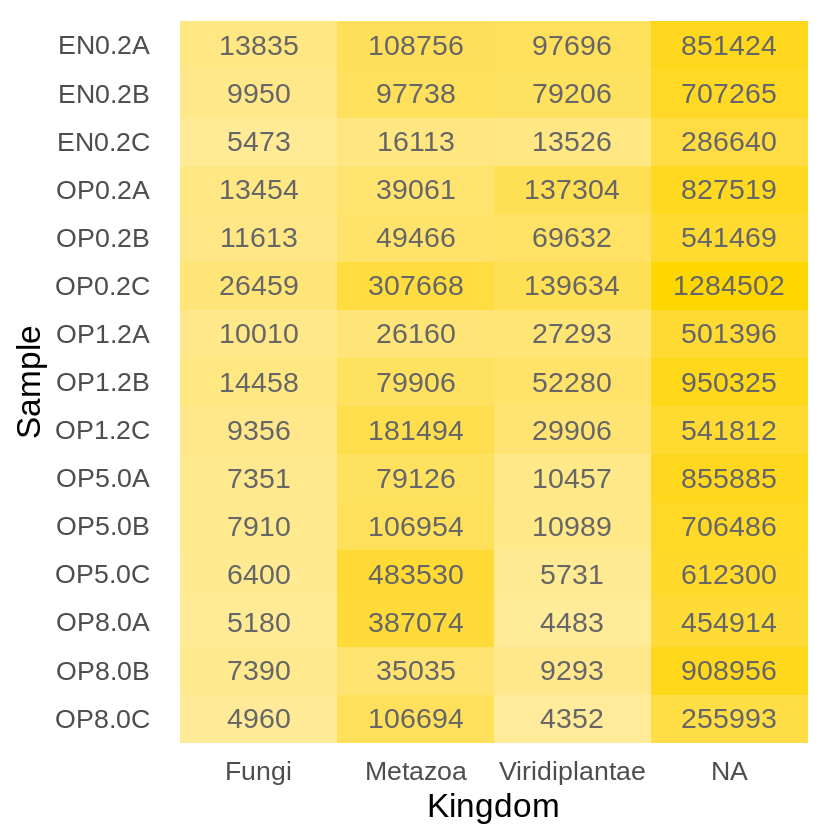

In [20]:
# Kingdoms
k <- dataset %>% group_by(kingdom,correct_sample) %>% summarise(value = sum(mean))
    #pivot_wider(names_from = variable, values_from = value) %>%

newnames <- c('EN0.2A','EN0.2B','EN0.2C','OP0.2A','OP0.2B','OP0.2C','OP1.2A','OP1.2B','OP1.2C','OP5.0A','OP5.0B','OP5.0C','OP8.0A','OP8.0B','OP8.0C')
k$correct_sample <- factor(k$correct_sample, levels = rev(newnames))

p <- k %>% ggplot() + geom_tile(aes(y=correct_sample, x=kingdom, fill=log2(value+1))) +
    geom_text(aes(y=correct_sample, x=kingdom, label=round(value,0)), color="gray40", size=6) +
    scale_fill_gradient(low = "#ffeb99", high = "gold", guide = "colorbar") +
    labs(y="Sample", x="Kingdom") +
    guides(fill=F) +
    theme_classic(base_size=20) %+replace% theme(axis.line = element_blank(),
                                                 axis.ticks = element_blank())

png(file="GenomeDK_Metabar/kingdom.metabar.reads.png", width=2300, height=2000, res=300)
p
dev.off()

In [22]:
# Overall per kingdoms
kinmat <- taxamat %>% select(correct_sample, perc, kingdom) %>% group_by(correct_sample, kingdom) %>% summarize(perc = sum(perc))
kinmat$correct_sample <- factor(kinmat$correct_sample, levels = newnames)
kinmat <- kinmat %>% mutate(type = ifelse(grepl("EN", correct_sample), "Enclosed", "Open"))

p <- kinmat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc,fill=kingdom), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Kingdom") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8))

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = 0.28*gt$widths[5]

png(file="GenomeDK_Metabar/bars.metabar.kingdom.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


png 
  2

**Phylum**

In [24]:
# Plot Phylum
phylmat <- taxamat %>% select(correct_sample, perc, phylum) %>%  group_by(correct_sample, phylum) %>% summarize(perc = sum(perc))
phylmat$correct_sample <- factor(phylmat$correct_sample, levels = newnames)
phylmat <- phylmat %>% mutate(type = ifelse(grepl("EN", correct_sample), "Enclosed", "Open"))

p <- phylmat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc,fill=phylum), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Phylum") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8),
                                 legend.position = "top")

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = unit(0.28, "null")

png(file="GenomeDK_Metabar/bars.metabar.phylum.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


png 
  2

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


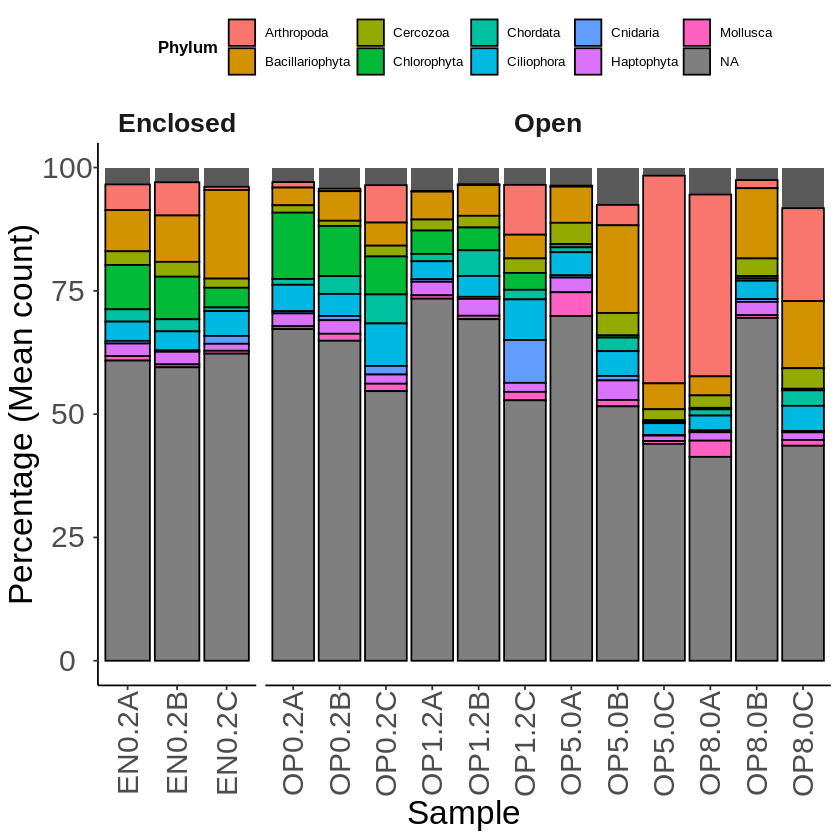

In [32]:
# Top 5 phyla
top5phyl <- phylmat %>% group_by(correct_sample, phylum) %>% summarize(perc = sum(perc)) %>%
arrange(correct_sample, desc(perc)) %>% slice(1:6)

# Save top10 table
top5phyl_table <- phylmat %>% select(correct_sample, phylum, perc) %>% filter(phylum %in% unique(top5phyl$phylum)) %>%
pivot_wider(names_from = correct_sample, values_from = perc)
write.table(top5phyl_table, file = "top5.phyl.metabar.mean.tsv", row.names = F, sep="\t")

p <- phylmat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc)) +
 geom_col(data=subset(phylmat, phylum %in% unique(top5phyl$phylum)), aes(x=correct_sample,y=perc, fill=phylum), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Phylum") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8),
                                 legend.position = "top")

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = unit(0.28, "null")

png(file="bars.metabar.phylum.top5.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

In [33]:
# Most abundant phyla
numbers <- phylmat %>% group_by(correct_sample, phylum) %>% summarize(perc = sum(perc)) %>%
arrange(correct_sample, desc(perc)) %>% slice(1:6) %>% ungroup() %>% group_by(phylum) %>% summarise(count = n())

abundances <- phylmat %>% group_by(correct_sample, phylum) %>% summarize(perc = sum(perc)) %>%
arrange(correct_sample, desc(perc)) %>% slice(1:6) %>% ungroup() %>% select(phylum, perc) %>%
group_by(phylum) %>% summarise(perc = sum(perc)/15) %>% arrange(desc(perc))

phylmostabun <- merge(numbers, abundances) %>% mutate(value = count * perc) %>% arrange(desc(value))

write.table(phylmostabun, file = "mostabund.phyl.metabar.mean.tsv", row.names = F, sep="\t")

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


**Family**

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


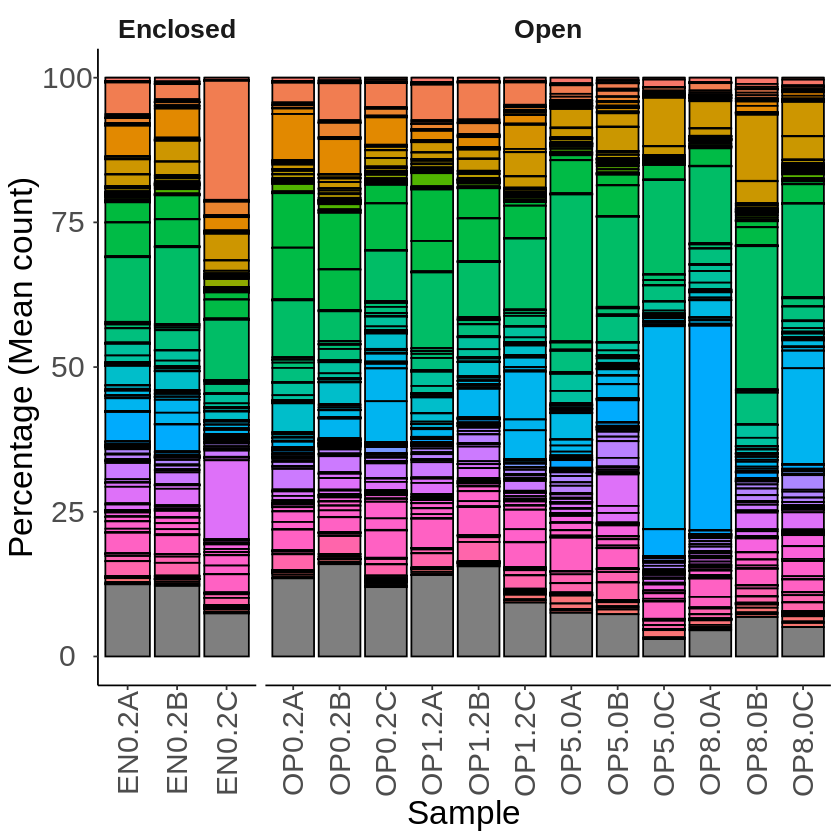

In [35]:
# Plot Family
fammat <- taxamat %>% select(correct_sample, perc, family) %>%  group_by(correct_sample, family) %>% summarize(perc = sum(perc))
fammat$correct_sample <- factor(fammat$correct_sample, levels = newnames)
fammat <- fammat %>% mutate(type = ifelse(grepl("EN", correct_sample), "Enclosed", "Open"))

p <- fammat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc,fill=family), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Family") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8),
                                 legend.position = "none")

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = unit(0.28, "null")

#png(file="GenomeDK_Metabar/bars.metabar.family.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

In [39]:
# Top 10 family
top10fam <- fammat %>% group_by(correct_sample, family) %>% summarize(perc = sum(perc)) %>%
arrange(correct_sample, desc(perc)) %>% slice(1:11)

# Save top10 table
top10fam_table <- fammat %>% select(correct_sample, family, perc) %>% filter(family %in% unique(top10fam$family)) %>%
pivot_wider(names_from = correct_sample, values_from = perc)
write.table(top10fam_table, file = "top10.fam.metabar.mean.tsv", row.names = F, sep="\t")

p <- fammat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc)) +
 geom_col(data=subset(fammat, family %in% unique(top10fam$family)), aes(x=correct_sample,y=perc, fill=family), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Family") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8),
                                 legend.position = "top")

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = unit(0.28,"null")

png(file="GenomeDK_Metabar/bars.metabar.family.top10.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


png 
  2

**Genus**

In [41]:
# Plot Genus
genmat <- taxamat %>% select(correct_sample, perc, genus) %>%  group_by(correct_sample, genus) %>% summarize(perc = sum(perc))
genmat$correct_sample <- factor(genmat$correct_sample, levels = newnames)
genmat <- genmat %>% mutate(type = ifelse(grepl("EN", correct_sample), "Enclosed", "Open"))

p <- genmat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc,fill=genus), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Genus") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8),
                                 legend.position = "none")

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = unit(0.28,"null")

png(file="GenomeDK_Metabar/bars.metabar.genus.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


png 
  2

In [43]:
# Top 10 genus
top10gen <- genmat %>% group_by(correct_sample, genus) %>% summarize(perc = sum(perc)) %>%
arrange(correct_sample, desc(perc)) %>% slice(1:11)

# Save top10 table
top10gen_table <- genmat %>% select(correct_sample, genus, perc) %>% filter(genus %in% unique(top10gen$genus)) %>%
pivot_wider(names_from = correct_sample, values_from = perc)
write.table(top10gen_table, file = "top10.gen.metabar.mean.tsv", row.names = F, sep="\t")

p <- genmat %>% ggplot() + geom_col(aes(x=correct_sample,y=perc)) +
 geom_col(data=subset(genmat, genus %in% unique(top10gen$genus)), aes(x=correct_sample,y=perc, fill=genus), color="black") +
 labs(x = "Sample", y = "Percentage (Mean count)", fill="Genus") +
 facet_wrap(~type, scales="free_x") +
 theme_classic() %+replace% theme(axis.text.x = element_text(angle = 90, size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 strip.text.x = element_text(size = 16, face="bold"),
                                 strip.background = element_blank(),
                                 legend.title = element_text(size=10, face="bold"),
                                 legend.text = element_text(size=8),
                                 legend.position = "top")

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = unit(0.28,"null")

png(file="GenomeDK_Metabar/bars.metabar.genus.top10.mean.png", width=2300, height=2000, res=300)
grid.draw(gt)
dev.off()

`summarise()` has grouped output by 'correct_sample'. You can override using the
`.groups` argument.


png 
  2